In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression


# Set Matplotlib defaults  >>>  jeter coup d'oeuil à l'occaz
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


/tmp/ipykernel_18/185306933.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
import warnings

# Ignore all FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Ignore all DeprecationWarnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# 1_EDA

In [3]:
dir_path = "/kaggle/input/store-sales-time-series-forecasting/"

## 1_1  Oil File

In [4]:
file_path = dir_path + "oil.csv"

df_oil = pd.read_csv(
    file_path,
    parse_dates=['date'])

df_oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [5]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [6]:
df_oil.isna().sum()


date           0
dcoilwtico    43
dtype: int64

In [7]:
(df_oil == 0).sum()

date          0
dcoilwtico    0
dtype: int64

## 1_2 Holidays File

In [8]:
file_path = dir_path + "holidays_events.csv"


df_holidays = pd.read_csv(
    file_path,
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
)
df_holidays = df_holidays.set_index('date').to_period('D')



df_holidays

## a terminer, un peu de trucs à comprendre je pense

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


## 1_3 Stores File

## 1_4 Train File

In [9]:
file_path = dir_path + "train.csv"

df_sales = pd.read_csv(
    file_path,
    dtype= {
        'store_nb':    'category',
        'family':      'category',
        'sales':       'float',
        'onpromotion': 'uint32'
        },
    parse_dates= ['date']
    )
 
df_sales['date'] = df_sales.date.dt.to_period('D')
df_sales = df_sales.set_index('id')


In [10]:
df_sales

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148


In [11]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype    
---  ------       -----    
 0   date         period[D]
 1   store_nbr    int64    
 2   family       category 
 3   sales        float64  
 4   onpromotion  uint32   
dtypes: category(1), float64(1), int64(1), period[D](1), uint32(1)
memory usage: 105.9 MB


## 1_5 Transactions File

# 2_   je sais pas quoi encore

In [12]:
for item in df_sales['family'].unique():
    print (item)

AUTOMOTIVE
BABY CARE
BEAUTY
BEVERAGES
BOOKS
BREAD/BAKERY
CELEBRATION
CLEANING
DAIRY
DELI
EGGS
FROZEN FOODS
GROCERY I
GROCERY II
HARDWARE
HOME AND KITCHEN I
HOME AND KITCHEN II
HOME APPLIANCES
HOME CARE
LADIESWEAR
LAWN AND GARDEN
LINGERIE
LIQUOR,WINE,BEER
MAGAZINES
MEATS
PERSONAL CARE
PET SUPPLIES
PLAYERS AND ELECTRONICS
POULTRY
PREPARED FOODS
PRODUCE
SCHOOL AND OFFICE SUPPLIES
SEAFOOD


In [13]:
# work on a sample

store_nbr = 1
family = 'EGGS'

df_sample = df_sales[
        (df_sales['store_nbr'] == store_nbr)
       &(df_sales['family']    == family   )
]

df_sample

,date,store_nbr,family,sales,onpromotion
id,,,,,
10,2013-01-01,1,EGGS,0.0,0
1792,2013-01-02,1,EGGS,246.0,0
3574,2013-01-03,1,EGGS,203.0,0
5356,2013-01-04,1,EGGS,171.0,0
7138,2013-01-05,1,EGGS,177.0,0
...,...,...,...,...,...
2991988,2017-08-11,1,EGGS,86.0,24
2993770,2017-08-12,1,EGGS,113.0,0
2995552,2017-08-13,1,EGGS,60.0,0


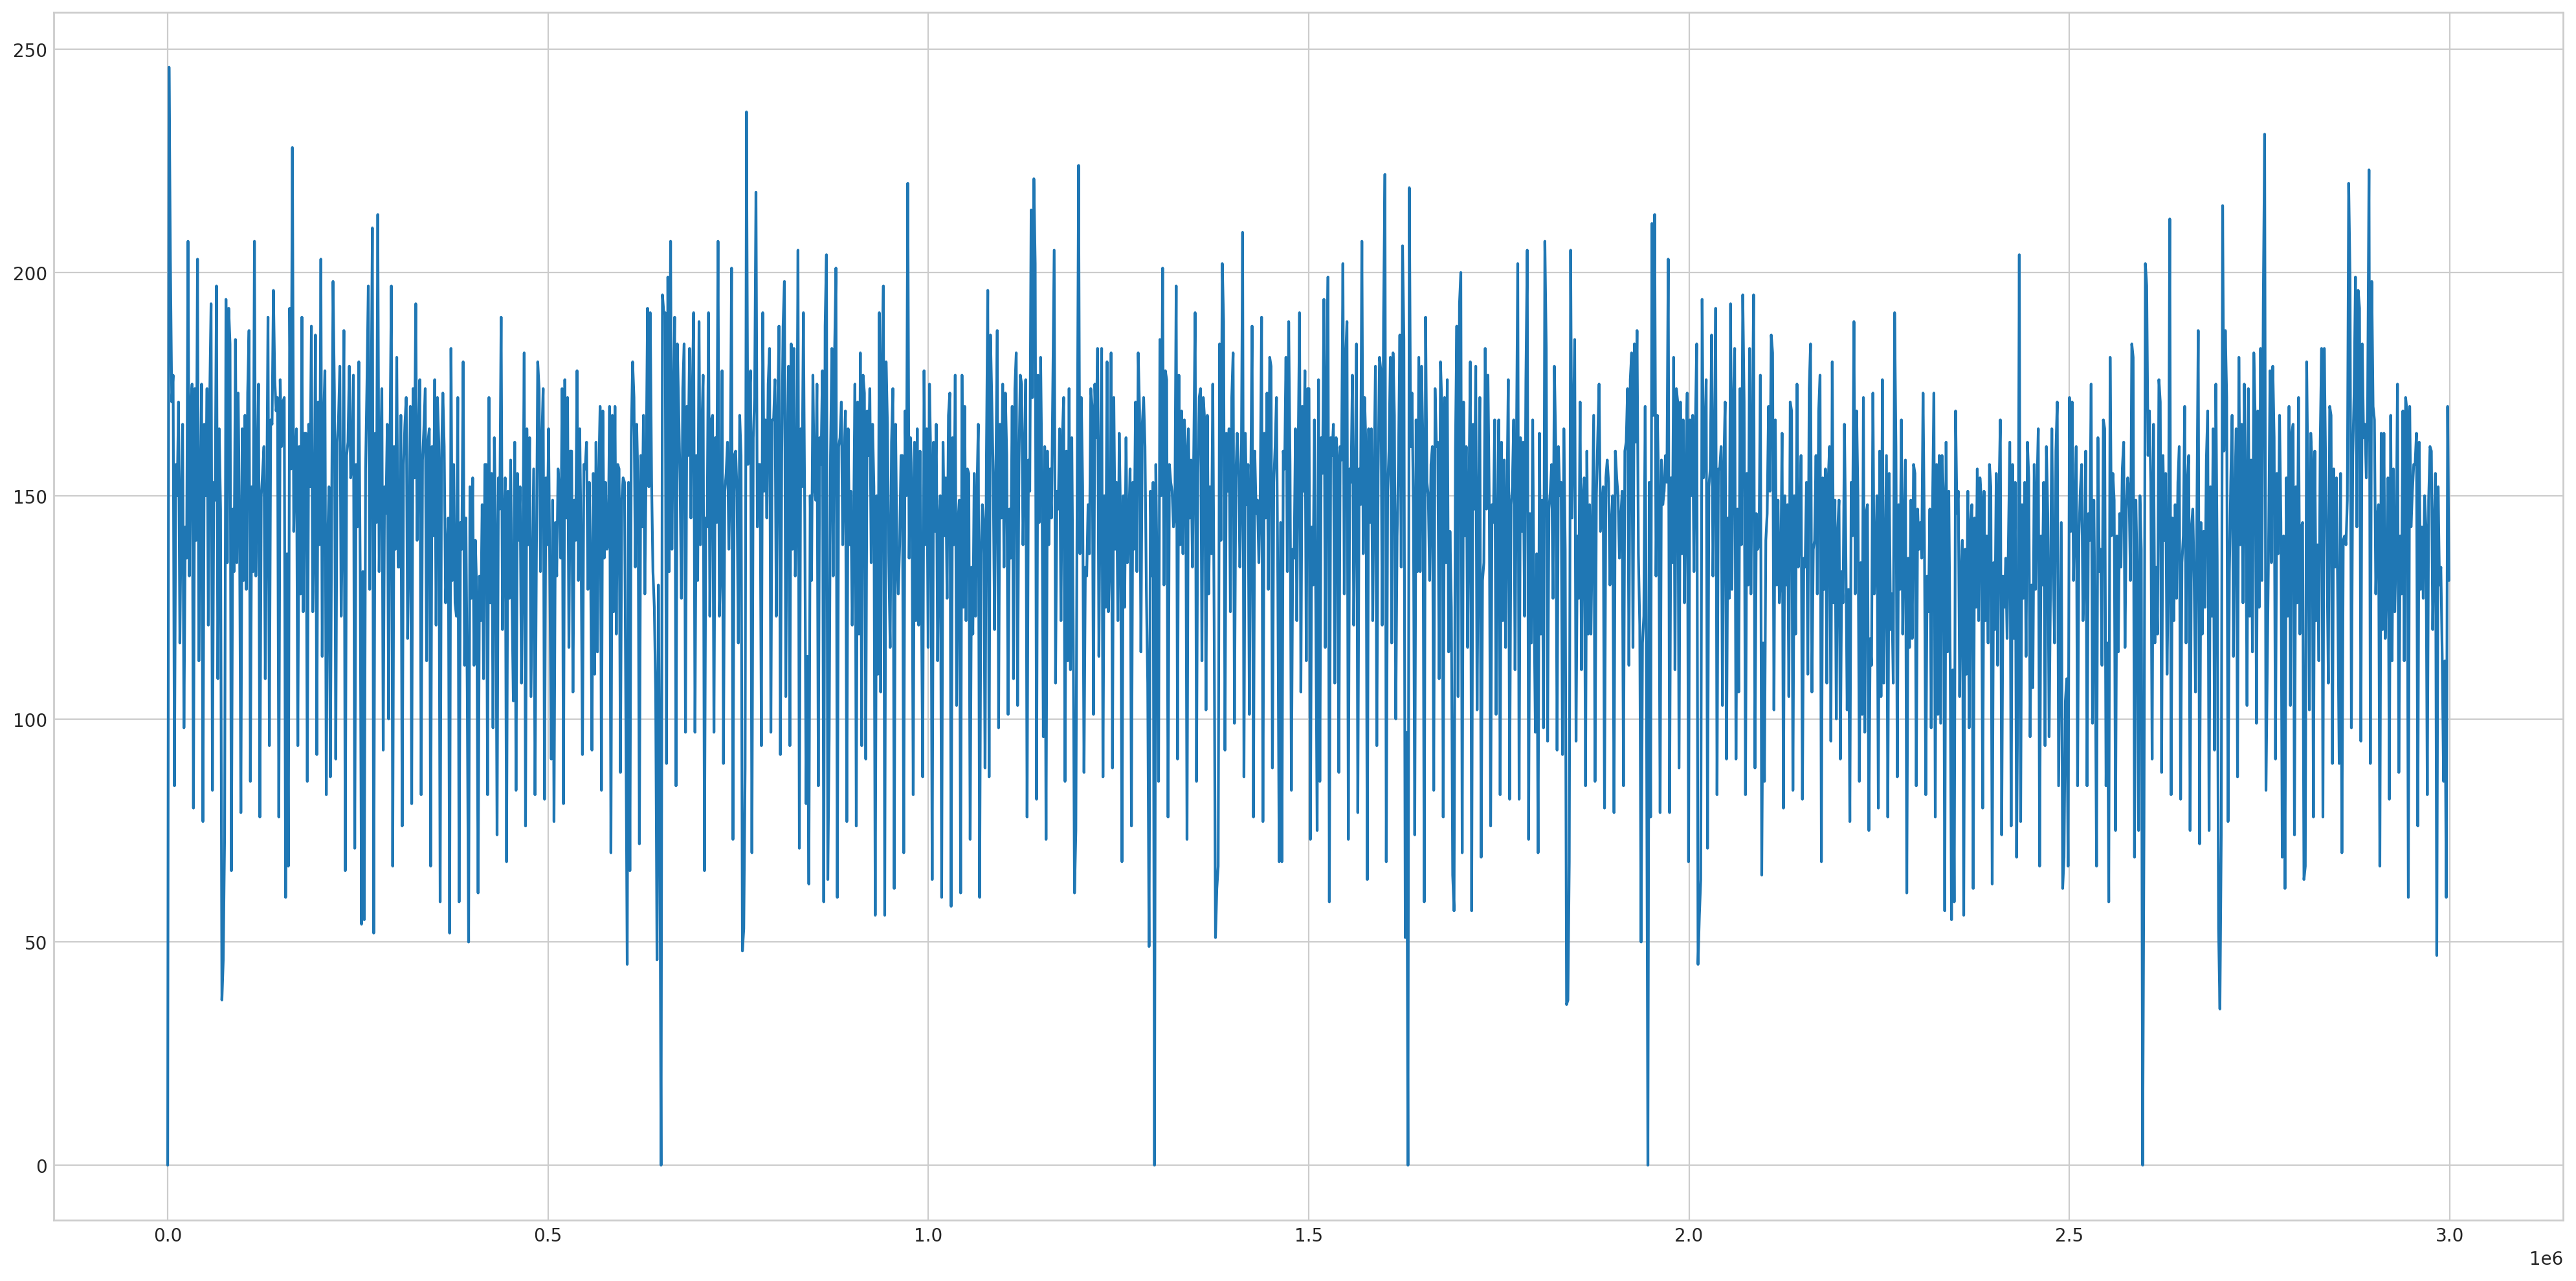

In [14]:
df = df_sample

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df["sales"])

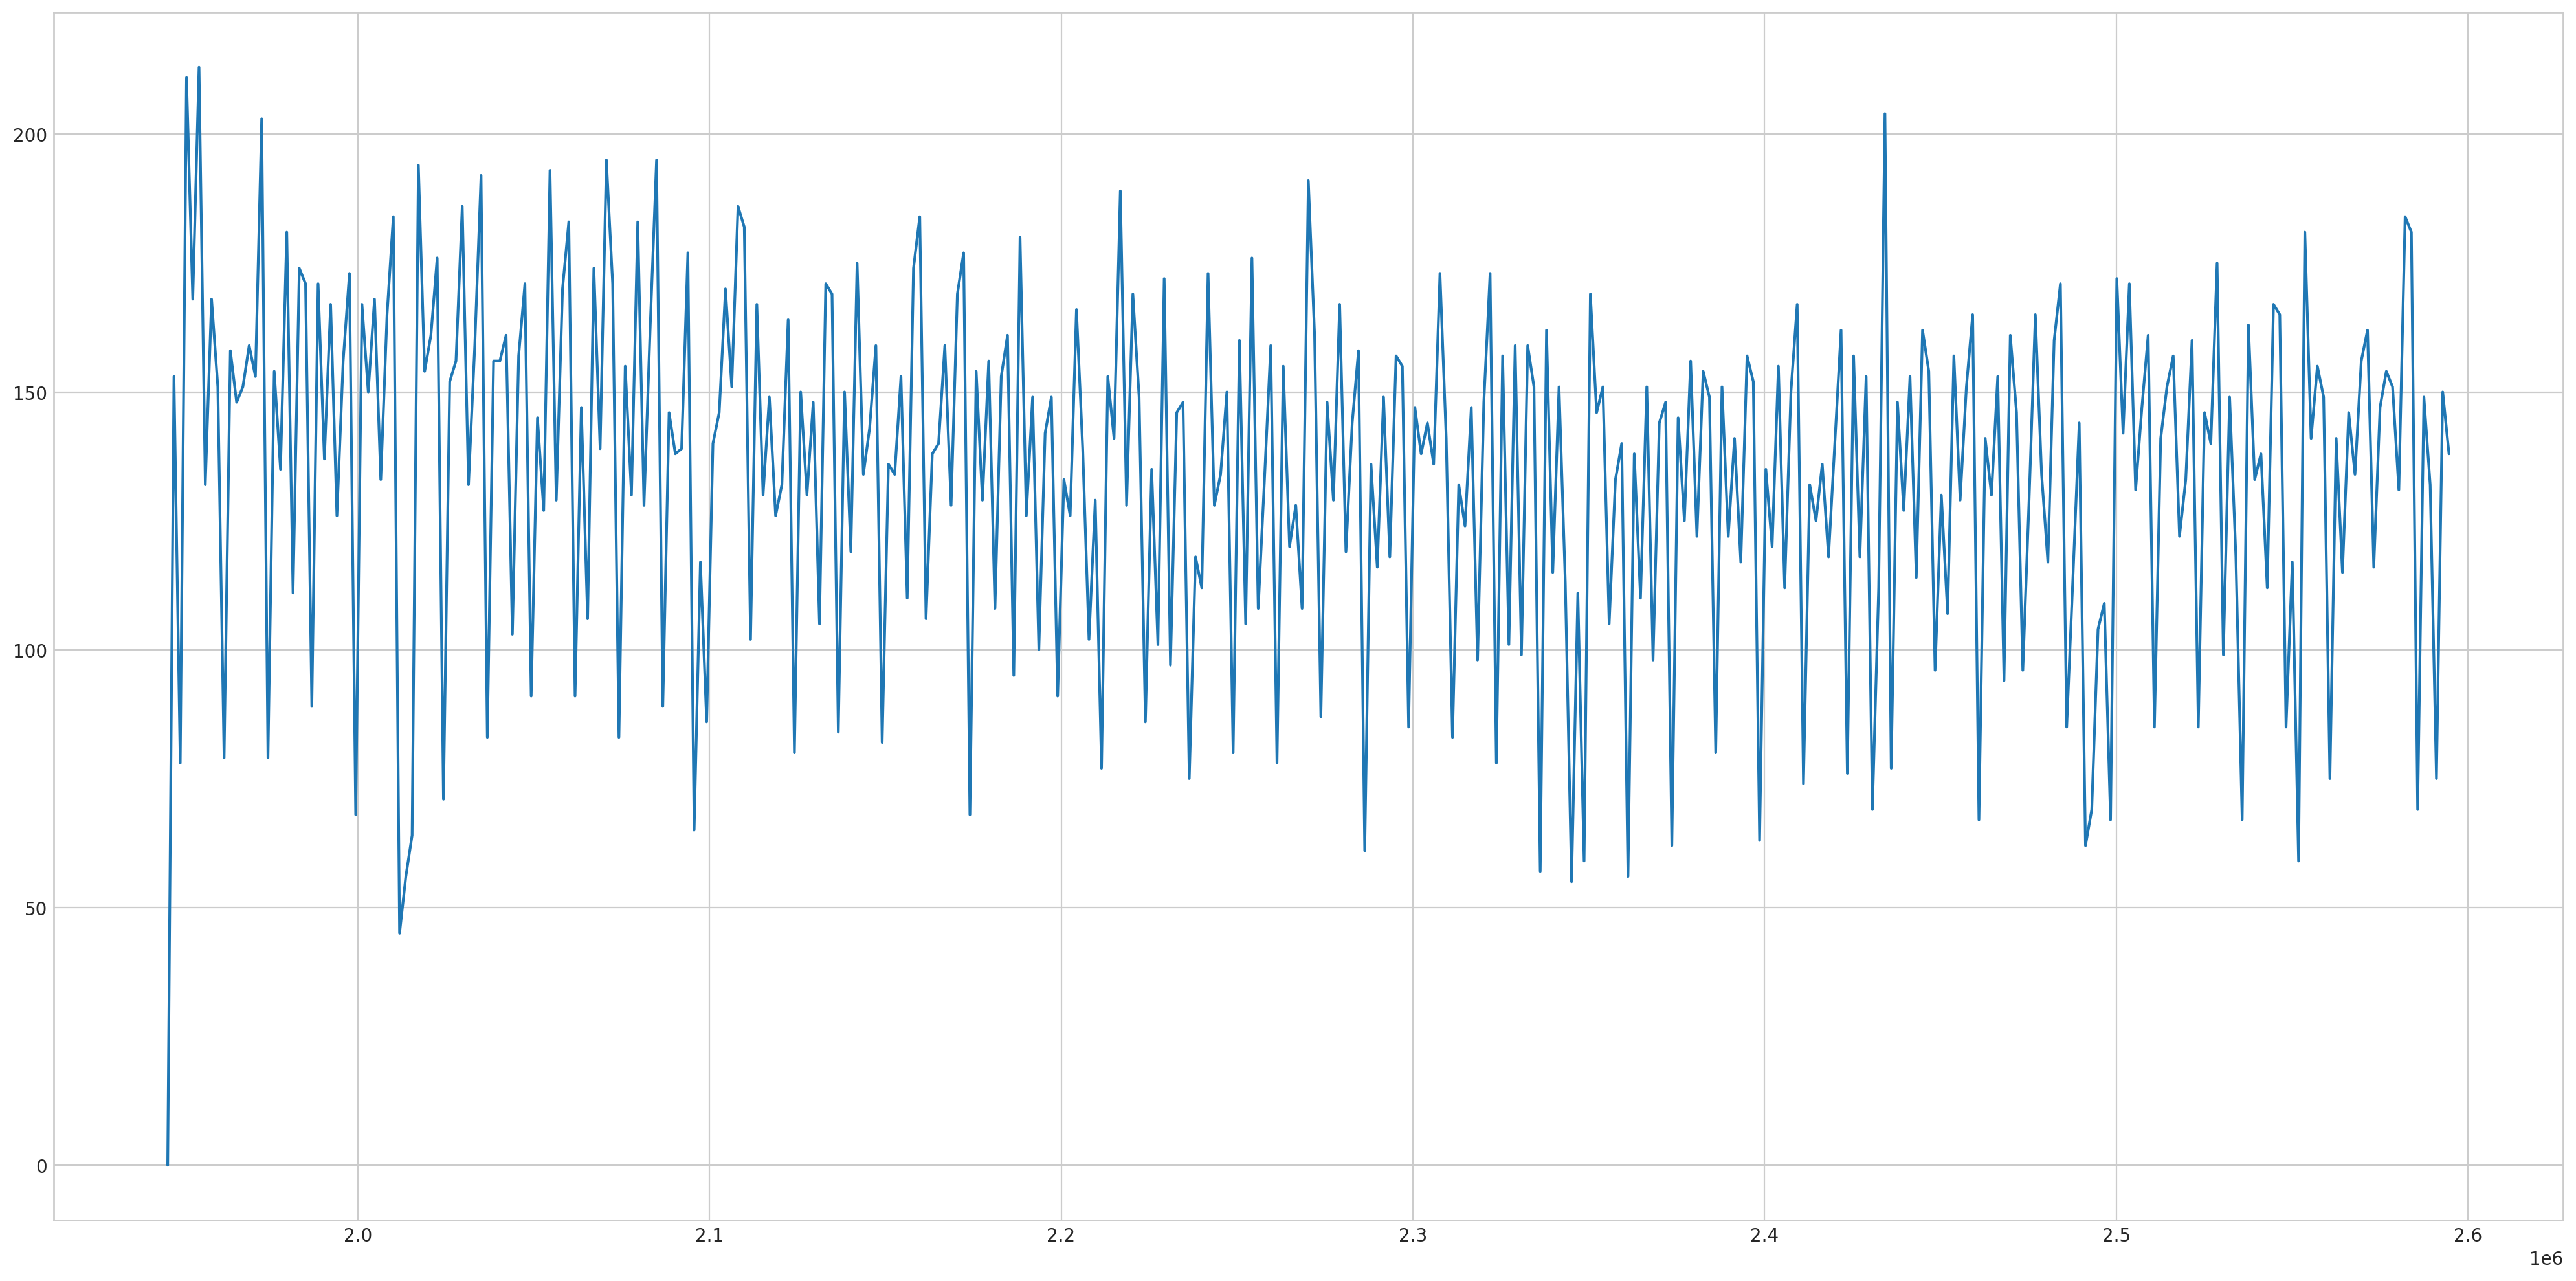

In [15]:
df = df_sample[(df_sample['date'].dt.year == 2016)]

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df["sales"])

# train on a another sample

In [16]:
file_path = dir_path + "train.csv"

df_sales = pd.read_csv(
    file_path,
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype= {
        'store_nb':    'category',
        'family':      'category',
        'sales':       'float',
        'onpromotion': 'uint32'
        },
    parse_dates= ['date'],
)
 
df_sales['date'] = df_sales.date.dt.to_period('D')
#df_sales = df_sales.set_index('id')

df_sales = df_sales.set_index(['store_nbr', 'family', 'date']).sort_index()  # a voir quel index on garde

df_average_sales = (
    df_sales
    .groupby('date').mean()
    .squeeze()  # transforme dataframe single column in Series
    .loc['2017']
)

print("done")

done


In [17]:
df_sales

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0
...                                ...
54        SEAFOOD    2017-08-11    0.0
                     2017-08-12    1.0
                     2017-08-13    2.0
                     2017-08-14    0.0
                     2017-08-15    3.0

[3000888 rows x 1 columns]

In [18]:
df_average_sales

date
2017-01-01      6.780304
2017-01-02    786.928379
2017-01-03    619.740224
2017-01-04    555.608004
2017-01-05    436.375395
                 ...    
2017-08-11    463.733851
2017-08-12    444.798280
2017-08-13    485.768618
2017-08-14    427.004717
2017-08-15    427.980884
Freq: D, Name: sales, Length: 227, dtype: float64

In [19]:
type(df_average_sales)

pandas.core.series.Series

In [20]:
##  peut etre regarder un jour comment ca fonctionne

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            (name,),
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

print("done")

done


In [21]:
# peut etre regarder un jour comment ca fonctionne

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

print("done")

done


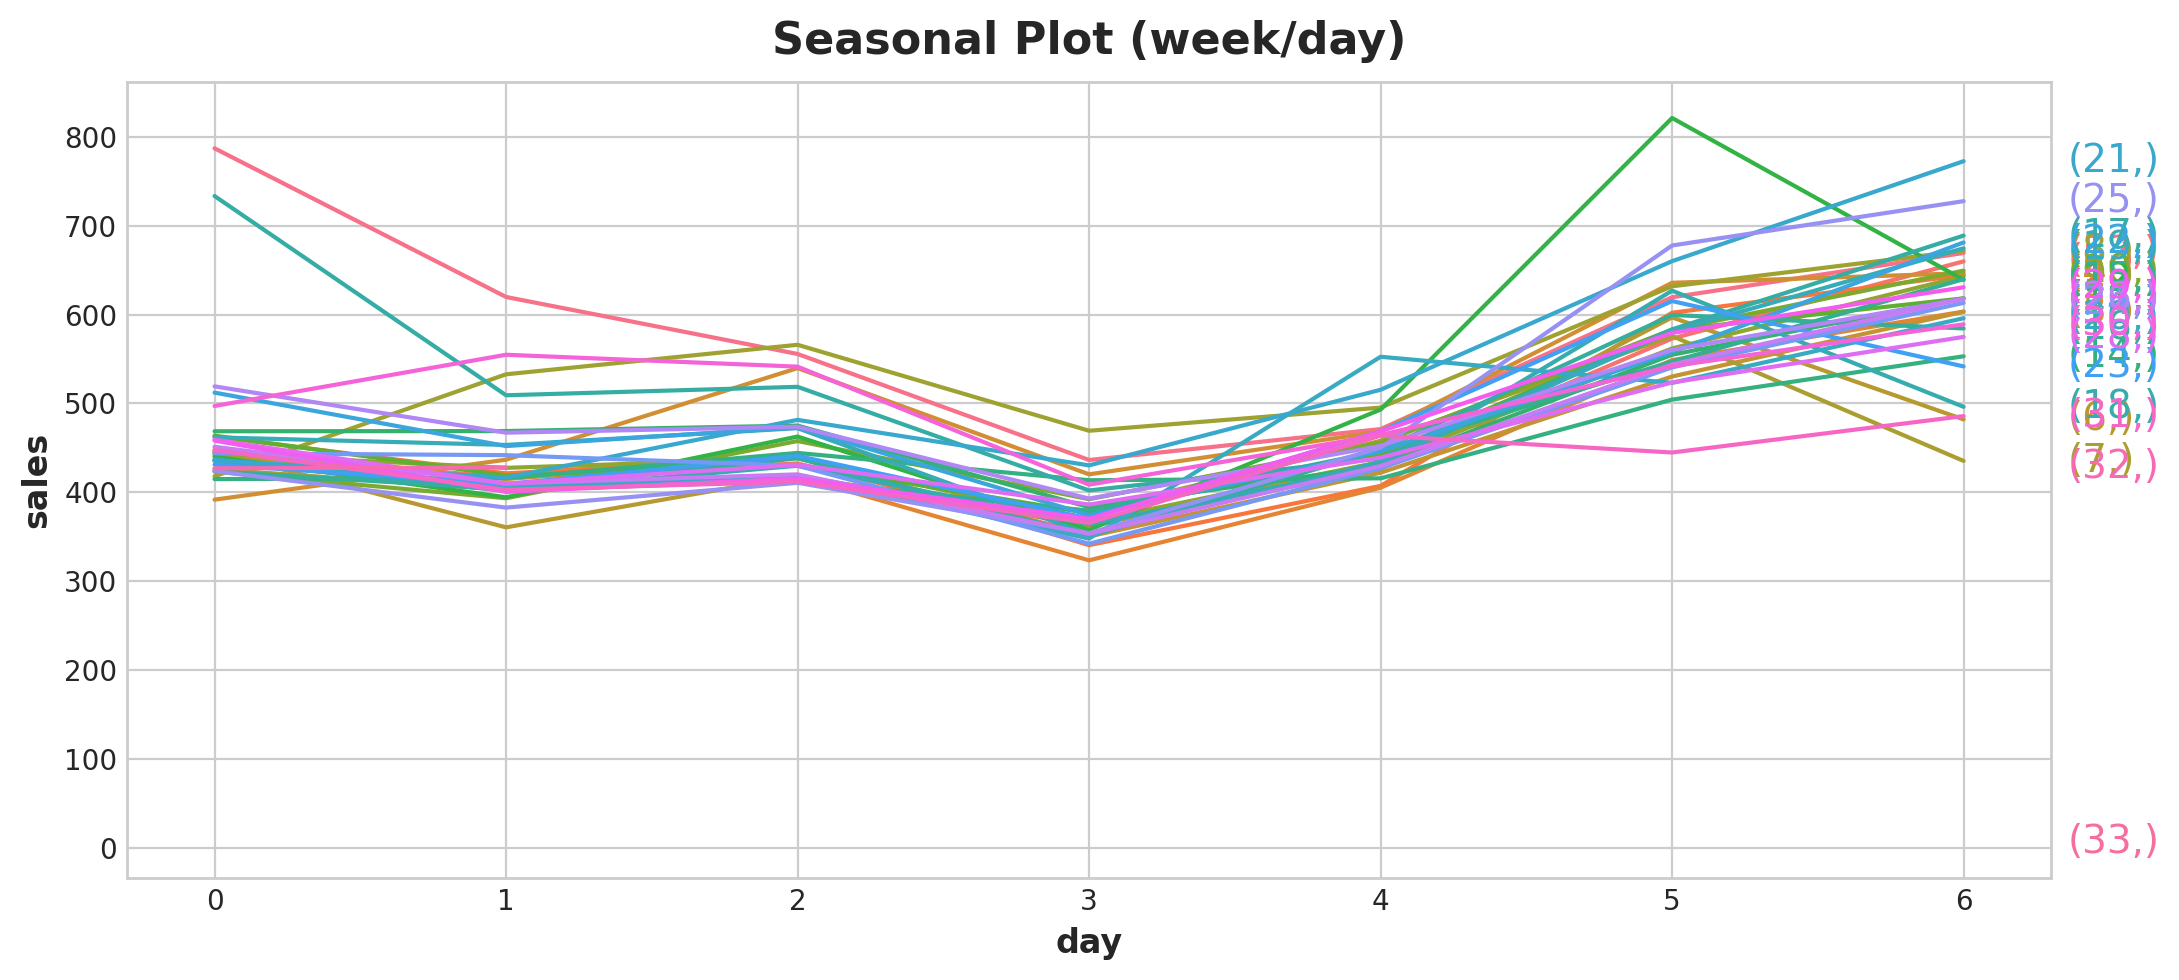

In [22]:
X = df_average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

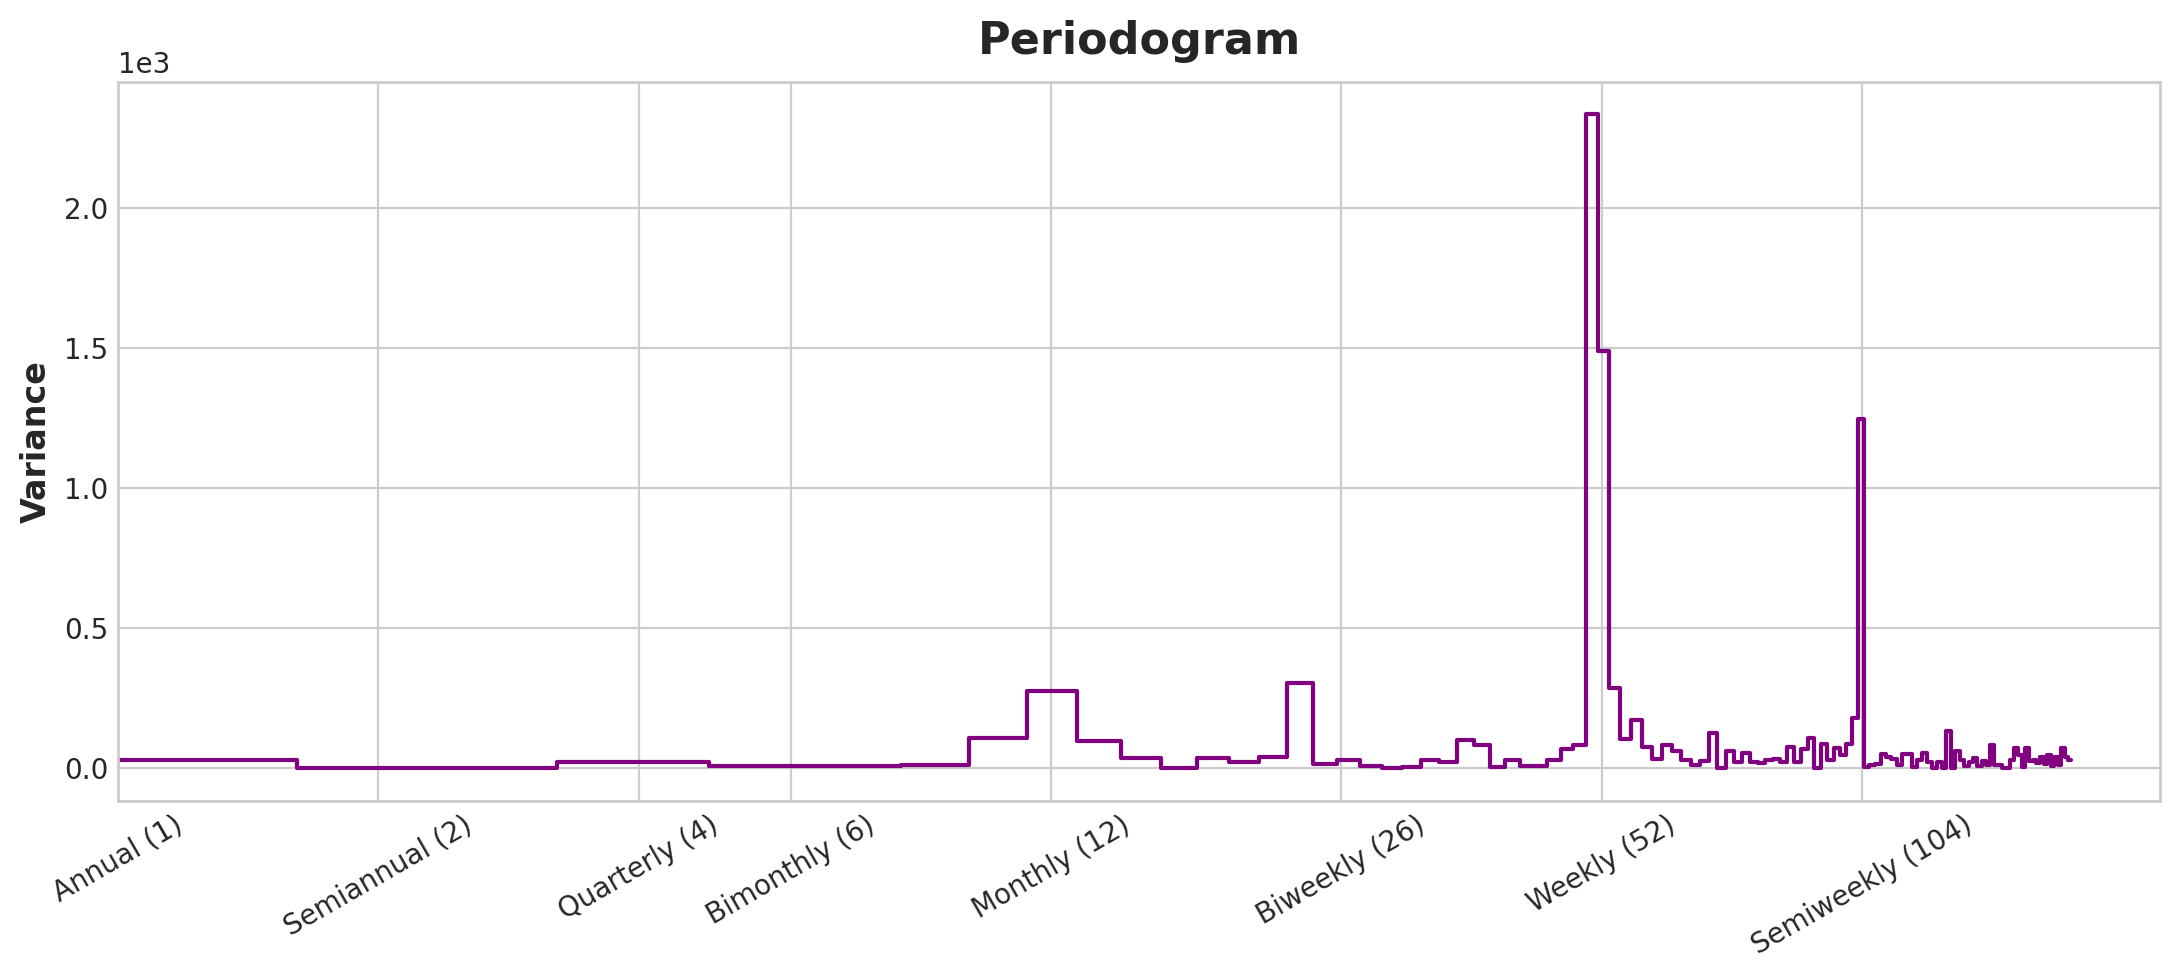

In [23]:
plot_periodogram(df_average_sales);

In [24]:
y = df_average_sales.copy()

# YOUR CODE HERE
fourier = CalendarFourier(freq='m', order=4)


dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    # YOUR CODE HERE
    seasonal= True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

print("done")


done


In [25]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139


In [26]:
model = LinearRegression()
model.fit (X,y)

print("done")

done


In [27]:
y_pred = pd.Series(model.predict(X), index= X.index)

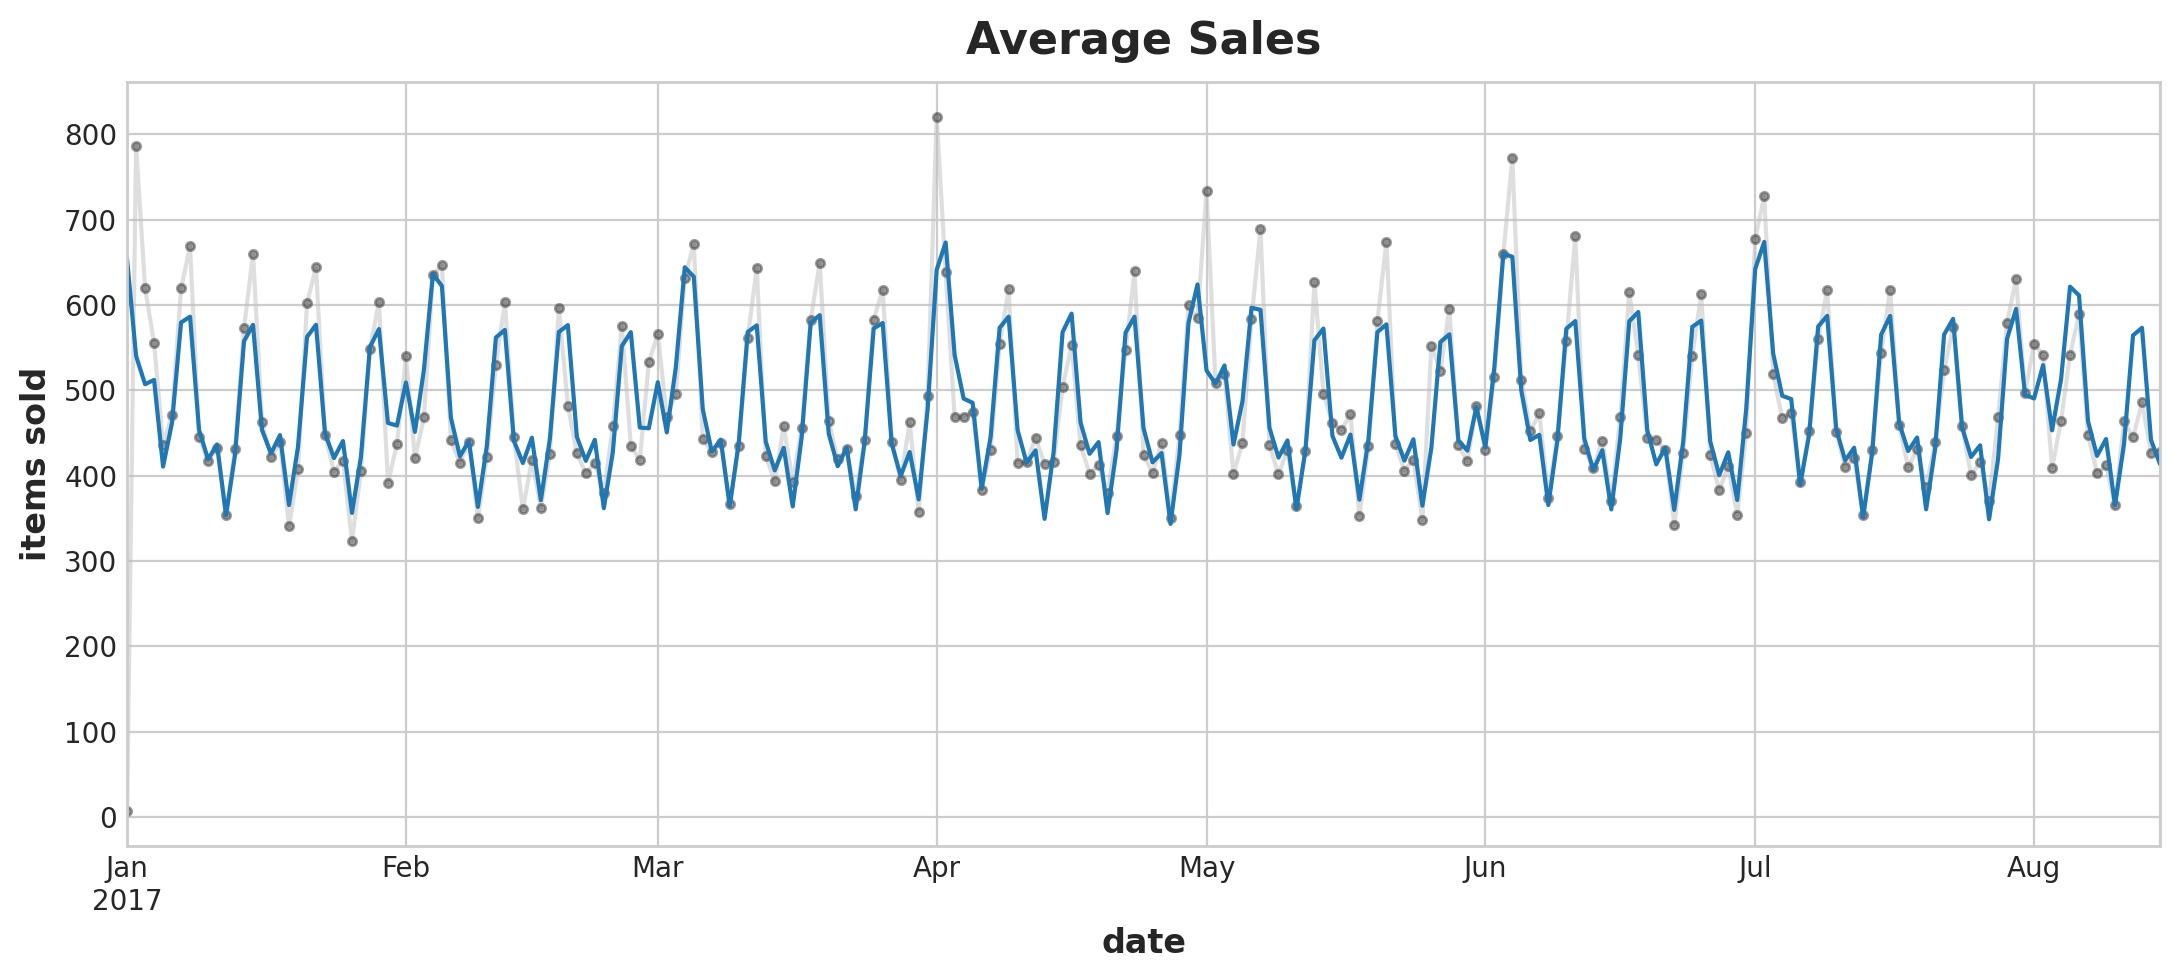

In [28]:
ax = y     .plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
#ax.legend();

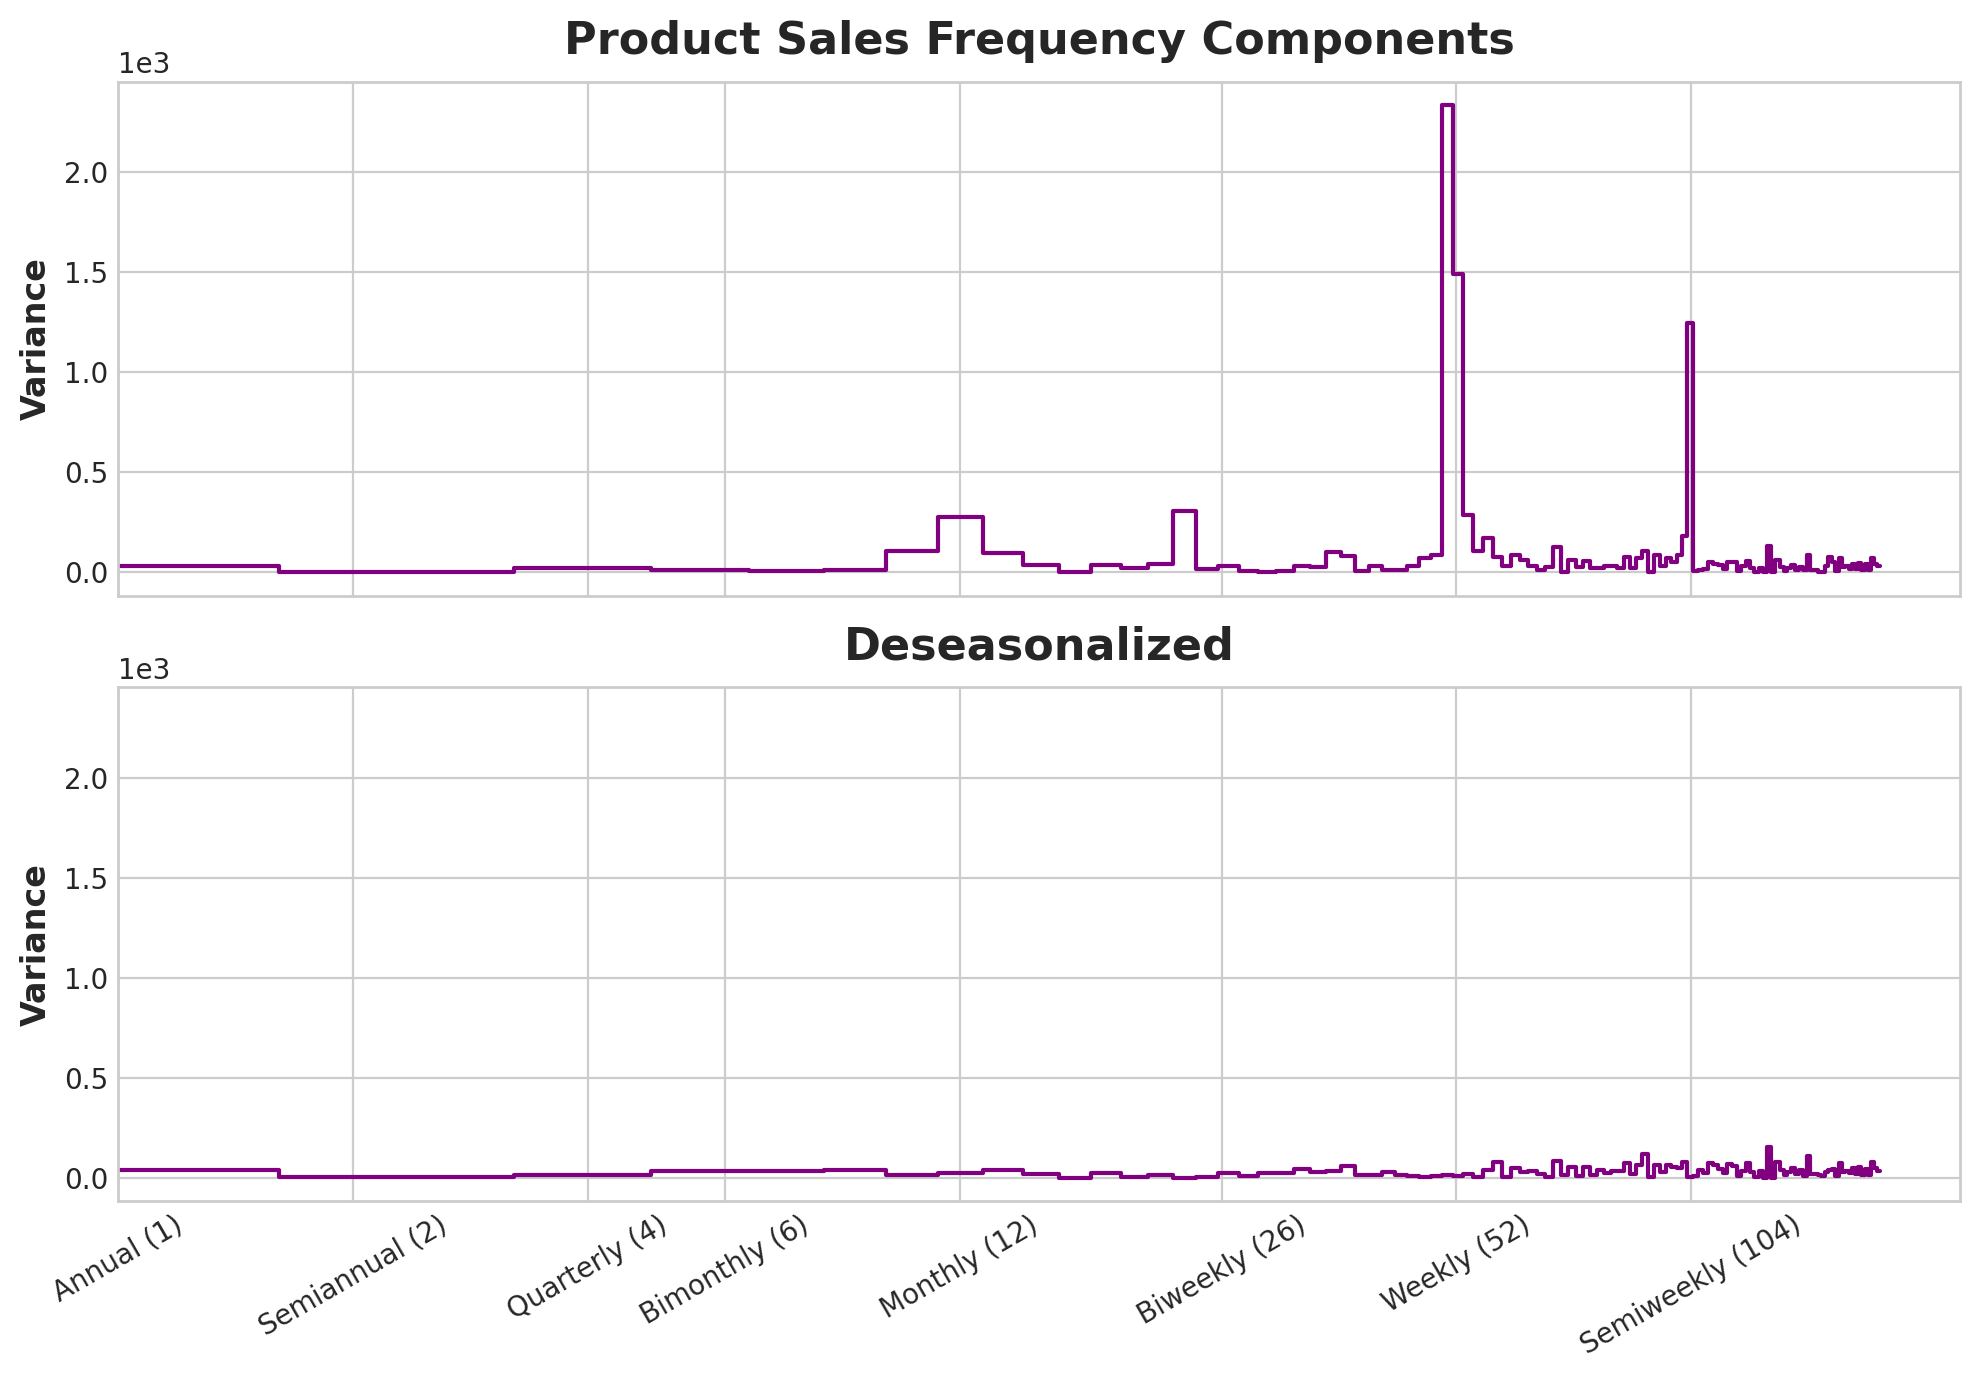

In [29]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

In [30]:
df_holidays

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [31]:
df_holidays["description"].cat.categories

Index(['Batalla de Pichincha', 'Black Friday', 'Cantonizacion de Cayambe',
       'Cantonizacion de El Carmen', 'Cantonizacion de Guaranda',
       'Cantonizacion de Latacunga', 'Cantonizacion de Libertad',
       'Cantonizacion de Quevedo', 'Cantonizacion de Riobamba',
       'Cantonizacion de Salinas',
       ...
       'Terremoto Manabi+7', 'Terremoto Manabi+8', 'Terremoto Manabi+9',
       'Traslado Batalla de Pichincha', 'Traslado Fundacion de Guayaquil',
       'Traslado Fundacion de Quito', 'Traslado Independencia de Guayaquil',
       'Traslado Primer Grito de Independencia', 'Traslado Primer dia del ano',
       'Viernes Santo'],
      dtype='object', length=103)

In [32]:
# National and regional holidays in the training set
df_holidays_light = (
    df_holidays
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-1', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(df_holidays_light)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


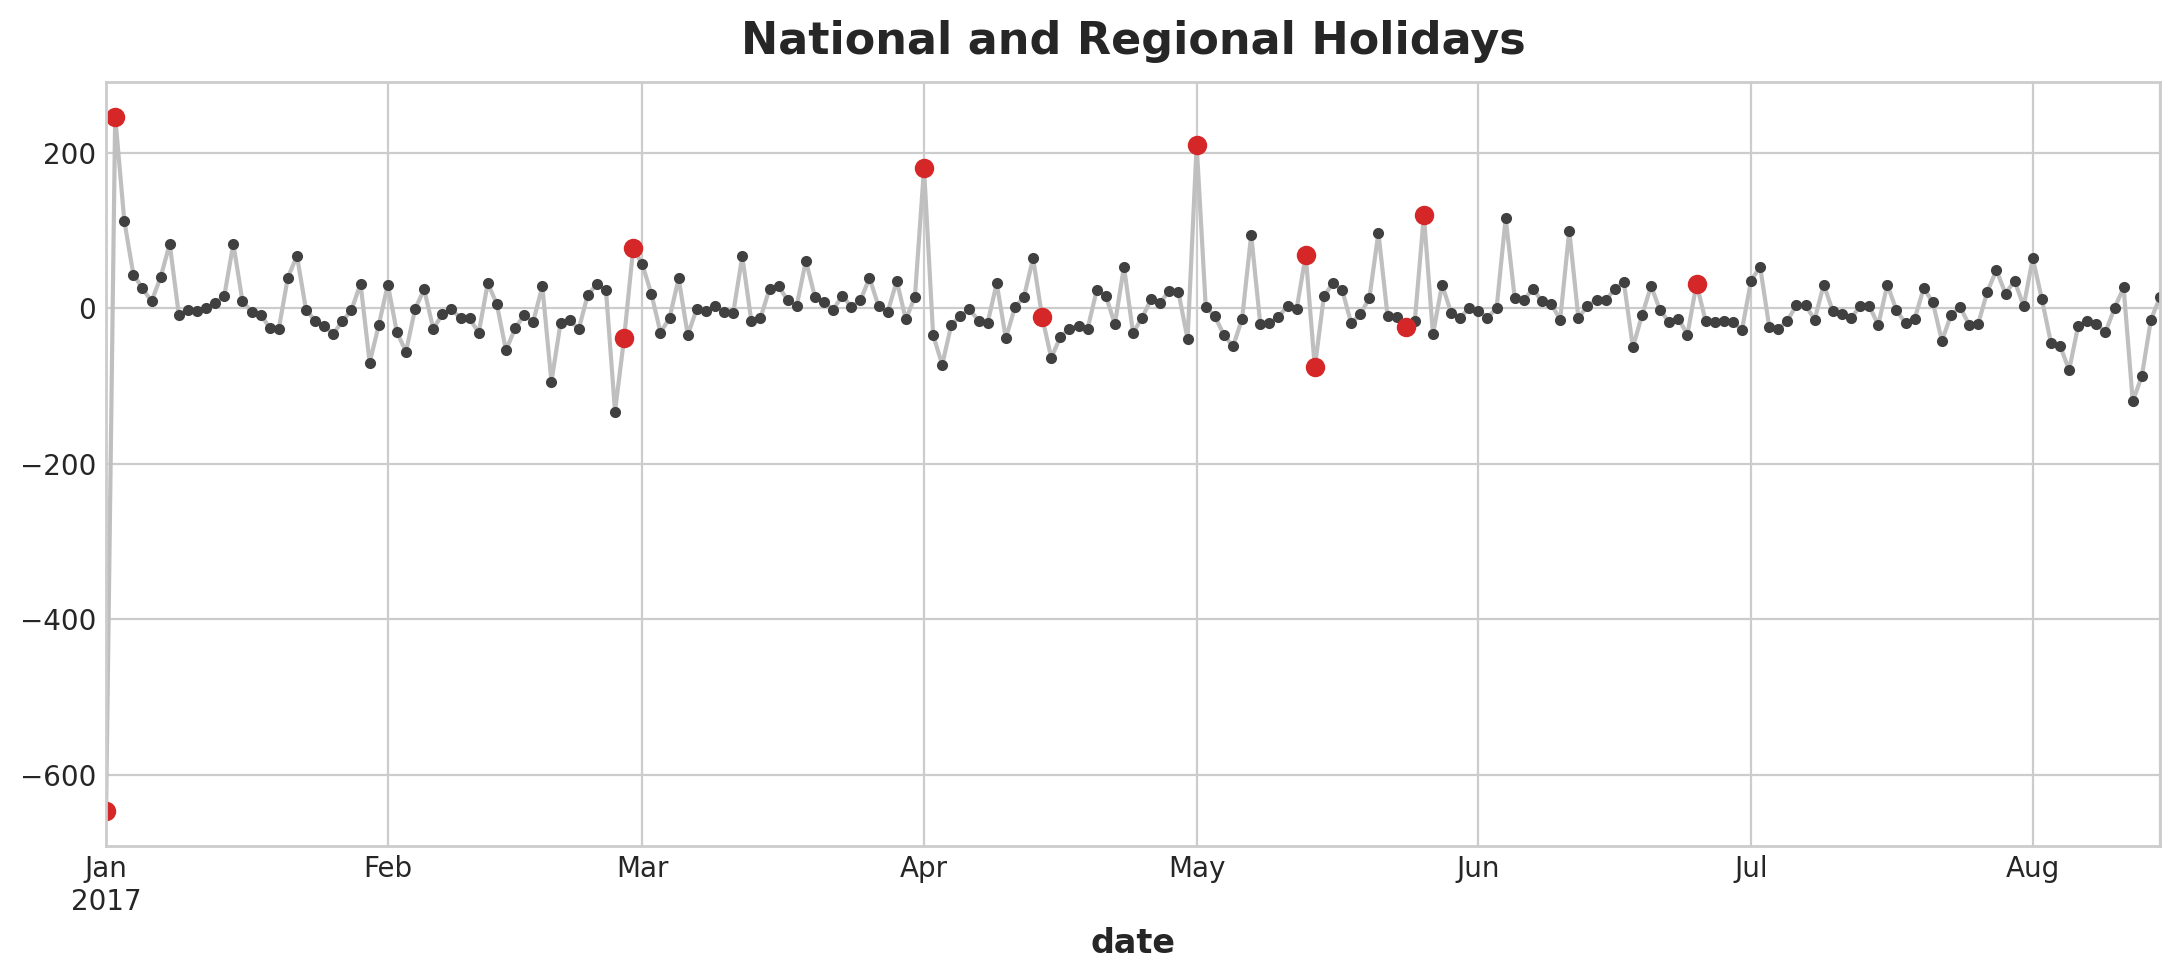

In [33]:
ax = y_deseason.plot(**plot_params)
ax.plot_date(df_holidays_light.index, y_deseason[df_holidays_light.index], color='C3');
ax.set_title('National and Regional Holidays');

In [34]:
X_holidays = pd.get_dummies(df_holidays_light)

X2 = X.join(X_holidays, on='date').fillna(False)

X2

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)",...,description_Carnaval,description_Dia de la Madre,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,False,False,False,False,True,False,False,False,False,False
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,False,False,False,False,False,False,False,False,True,False
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,False,False,False,False,False,False,False,False,False,False
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,False,False,False,False,False,False,False,False,False,False
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,...,False,False,False,False,False,False,False,False,False,False
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,...,False,False,False,False,False,False,False,False,False,False
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,...,False,False,False,False,False,False,False,False,False,False


In [35]:
model = LinearRegression()
model.fit(X2, y)




LinearRegression()

pourquoi pas toutes les dates de 2017 ???
score the result !


reflechir strategie globale : obj = learn et super score compete
> terminer totalement la methode kaggle sur ce petit set    
> ?? passer sur d'autres sets ?    
> tester autres methodes ztm    
> puis passer sur le set global
>
> cross validation ou au moins train test 


# Notes

is there better training score than RMS for the goal of this comp ?